Capture #0


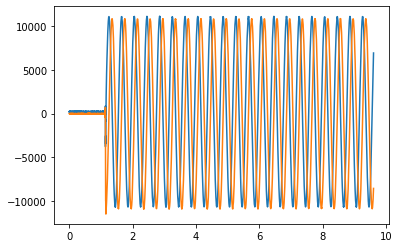

Capture #4


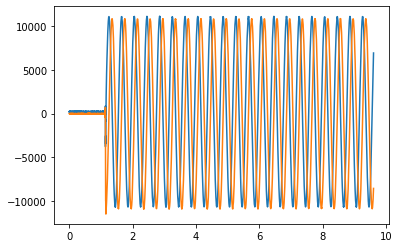

<Figure size 432x288 with 0 Axes>

In [26]:
## BEGIN OF TARGET CONFIGURATION

TARGET_QUBE = 'qube_ou_2-10.yml'
CAPTURE_DELAY = 0
SAVE_DIR = "result_send_recv/"
NUM_WAIT_VALUE = 16
TIME_OUT = 5

### END OF TARGET_CONFIGURATION

import sys
import os
import pathlib
import math
import argparse
import numpy as np

from e7awgsw import CaptureModule, AWG, AwgCtrl, CaptureCtrl, WaveSequence, CaptureParam, plot_graph
from e7awgsw.labrad import RemoteAwgCtrl, RemoteCaptureCtrl

d = {
    'PATH_TO_QUBECALIB': '{}/qube-calib/qubecalib'.format(os.getcwd()),
    'PATH_TO_E7AWGSW': '{}/qube-calib/e7awg_sw'.format(os.getcwd()),
    'PATH_TO_QUBELSI': '{}/qube-calib/adi_api_mod/python/qubelsi'.format(os.getcwd()),
    'PATH_TO_QUBEMASTER': '{}/qube_master/software'.format(os.getcwd()),
}
for k, p in d.items():
    if not p in sys.path:
        sys.path.insert(1, p)

import qubecalib as qc
import qubecalib.meas
import qubemasterclient

qc.qube.PATH_TO_API='{}/qube-calib/adi_api_mod'.format(os.getcwd())
qc.qube.PATH_TO_CONFIG='{}/qube-calib/.config'.format(os.getcwd())
qc.qube.PATH_TO_BITFILE='{}/qube_multi/bin_20220613'.format(os.getcwd())

qube = qc.Qube.create(TARGET_QUBE)
print(qube)

def set_trigger_awg(cap_ctrl, awg, capture_modules):
    for cap_mod_id in capture_modules:
        cap_ctrl.select_trigger_awg(cap_mod_id, awg)
        cap_ctrl.enable_start_trigger(*CaptureModule.get_units(cap_mod_id))


def gen_cos_wave(freq, num_cycles, amp):
    """
    freq : MHz
    """
    dt = 2.0 * math.pi * (freq * 1e6) / AwgCtrl.SAMPLING_RATE
    num_samples = int(num_cycles * AwgCtrl.SAMPLING_RATE / (freq * 1e6))
    i_data =  [int(amp * math.cos(i * dt)) for i in range(num_samples)]
    q_data =  [int(amp * math.sin(i * dt)) for i in range(num_samples)]
    return list(zip(i_data, q_data))


def gen_wave_seq(num_wait_words=16):
    wave_seq = WaveSequence(
        num_wait_words = num_wait_words,
        num_repeats = 1)
    
    num_chunks = 1
    for i in range(num_chunks):
        samples = gen_cos_wave(2.5, 8, 5000)
        # 1 波形チャンクのサンプル数は 64 の倍数でなければならない
        num_samples_in_wblcok = WaveSequence.NUM_SAMPLES_IN_WAVE_BLOCK
        if len(samples) % num_samples_in_wblcok != 0:
            additional_samples = num_samples_in_wblcok - (len(samples) % num_samples_in_wblcok)
            samples.extend([(0, 0)] * additional_samples)
        wave_seq.add_chunk(
            iq_samples = samples, # 50MHz cos x2
            num_blank_words = 0, 
            num_repeats = 3)
    return wave_seq


def set_wave_sequence(awg_ctrl, awgs, num_wait_words=16):
    awg_to_wave_sequence = {}
    wave_seq = gen_wave_seq(num_wait_words)
    for awg_id in awgs:
        awg_to_wave_sequence[awg_id] = wave_seq
        awg_ctrl.set_wave_sequence(awg_id, wave_seq)
    return awg_to_wave_sequence


def set_capture_params(cap_ctrl, wave_seq, capture_units):
    capture_param = gen_capture_param(wave_seq)
    for captu_unit_id in capture_units:
        cap_ctrl.set_capture_params(captu_unit_id, capture_param)


def gen_capture_param(wave_seq):
    capture_param = CaptureParam()
    capture_param.num_integ_sections = 1
    capture_param.add_sum_section(wave_seq.num_all_words - wave_seq.num_wait_words, 1) # 総和区間を 1 つだけ定義する
    capture_param.capture_delay = CAPTURE_DELAY
    return capture_param


def get_capture_data(cap_ctrl, capture_units):
    capture_unit_to_capture_data = {}
    for capture_unit_id in capture_units:
        num_captured_samples = cap_ctrl.num_captured_samples(capture_unit_id)
        capture_unit_to_capture_data[capture_unit_id] = cap_ctrl.get_capture_data(capture_unit_id, num_captured_samples)
    return capture_unit_to_capture_data


def save_wave_data(prefix, sampling_rate, id_to_samples, save_dir=SAVE_DIR):
    for id, samples in id_to_samples.items():
        dir = save_dir + '/{}_{}'.format(prefix, id)
        os.makedirs(dir, exist_ok = True)
        print('save {} {} data'.format(prefix, id))

        # I/Q データテキストファイル保存
        filepath = dir + '/{}_{}.txt'.format(prefix, id)
        with open(filepath, 'w') as txt_file:
            for i_data, q_data in samples:
                txt_file.write("{}  ,  {}\n".format(i_data, q_data))

        # I データグラフ保存
        i_data = [sample[0] for sample in samples]
        plot_graph(
            sampling_rate, 
            i_data, 
            '{}_{}_I'.format(prefix, id), 
            dir + '/{}_{}_I.png'.format(prefix, id),
            '#b44c97')

        # Q データグラフ保存
        q_data = [sample[1] for sample in samples]
        plot_graph(
            sampling_rate,
            q_data, 
            '{}_{}_Q'.format(prefix, id), 
            dir + '/{}_{}_Q.png'.format(prefix, id),
            '#00a497')


def check_err(awg_ctrl, cap_ctrl, awgs, capture_units):
    awg_to_err = awg_ctrl.check_err(*awgs)
    for awg_id, err_list in awg_to_err.items():
        print(awg_id)
        for err in err_list:
            print('    {}'.format(err))
    
    cap_unit_to_err = cap_ctrl.check_err(*capture_units)
    for cap_unit_id, err_list in cap_unit_to_err.items():
        print('{} err'.format(cap_unit_id))
        for err in err_list:
            print('    {}'.format(err))


def create_awg_ctrl(use_labrad, server_ip_addr, ip_addr):
    if use_labrad:
        return RemoteAwgCtrl(server_ip_addr, ip_addr)
    else:
        return AwgCtrl(ip_addr)


def create_capture_ctrl(use_labrad, server_ip_addr, ip_addr):
    if use_labrad:
        return RemoteCaptureCtrl(server_ip_addr, ip_addr)
    else:
        return CaptureCtrl(ip_addr)


def main(awgs, capture_modules, ip_addr, use_labrad, server_ip_addr, num_wait_words, save_dir=SAVE_DIR, timeout=5, use_sequencer=False, save_data=False):
    with (create_awg_ctrl(use_labrad, server_ip_addr, ip_addr) as awg_ctrl,
          create_capture_ctrl(use_labrad, server_ip_addr, ip_addr) as cap_ctrl):
        capture_units = CaptureModule.get_units(*capture_modules)
        # 初期化
        awg_ctrl.initialize(*awgs)
        cap_ctrl.initialize(*capture_units)
        # トリガ AWG の設定
        set_trigger_awg(cap_ctrl, awgs[0], capture_modules)
        # 波形シーケンスの設定
        awg_to_wave_sequence = set_wave_sequence(awg_ctrl, awgs, num_wait_words)
        # キャプチャパラメータの設定
        set_capture_params(cap_ctrl, awg_to_wave_sequence[awgs[0]], capture_units)
        if use_sequencer == False:
            # 波形送信スタート
            awg_ctrl.start_awgs(*awgs)
        else:
            print("wait for started by sequencer")
        # 波形送信完了待ち
        awg_ctrl.wait_for_awgs_to_stop(timeout, *awgs)
        # キャプチャ完了待ち
        cap_ctrl.wait_for_capture_units_to_stop(timeout, *capture_units)
        # エラーチェック
        check_err(awg_ctrl, cap_ctrl, awgs, capture_units)
        # キャプチャデータ取得
        capture_unit_to_capture_data = get_capture_data(cap_ctrl, capture_units)
        # 波形保存
        awg_to_wave_data = {awg: wave_seq.all_samples(False) for awg, wave_seq in awg_to_wave_sequence.items()}
        if save_data:
            save_wave_data('awg', AwgCtrl.SAMPLING_RATE, awg_to_wave_data, save_dir)
            save_wave_data('capture', CaptureCtrl.SAMPLING_RATE, capture_unit_to_capture_data, save_dir)
        return capture_unit_to_capture_data

awgs = AWG.all()
capture_modules = CaptureModule.all()
ret = main(awgs, capture_modules, qube.ipfpga, False, 'localhost', NUM_WAIT_VALUE, SAVE_DIR, TIME_OUT, False, False)

%matplotlib inline
import matplotlib.pyplot as plt

for i in [0,4]:
    print('Capture #{}'.format(i))
    s = slice(0,-1)
    a = np.array(ret[0])
    time = np.linspace(0, 1e+6 * a.shape[0] / CaptureCtrl.SAMPLING_RATE, a.shape[0], endpoint=False)
    plt.plot(time[s], a[s,0])
    plt.plot(time[s], a[s,1])
    plt.show()
    plt.clf()

In [15]:
qube.ipfpga

'10.1.0.14'